In [ ]:
!pip install albumentations

Augmentation

In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from glob import glob
import imageio.v2 as imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate, ShiftScaleRotate, RandomBrightnessContrast, ElasticTransform, GridDistortion
import random

def augmentation(images_path, masks_path, save_path):

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    images = sorted(glob(os.path.join(images_path, "*.png")))
    masks = sorted(glob(os.path.join(masks_path, "*.png")))
    print(images)

    for idx, (x,y) in tqdm(enumerate(zip(images, masks)), total = len(images)):

        ''' extracting number of image to give names'''
        # print(x)
        name_x = x.split('.')[0].split('/')[-1]
        name_y = y.split('.')[0].split('/')[-1]
        # print(name_x)

        # print(name_x)
        # print("X")

        '''reading images'''
        x = cv2.imread(x)
        # print(x)
        y = imageio.imread(y)

        y = y.astype(np.uint8)

        # unique_y = np.unique(y)
        # print(unique_y)
        unique_y = np.unique(y)

        # Check for empty or corrupt mask
        if y.size == 0 or np.all(y == 0):
            print(f"Warning: Mask {mask_path} is empty or all zeros.")
            pass

        # Skip processing if already binary in 0 and 255
        if len(unique_y) == 2 and set(unique_y) == {0, 255}:
            pass

        # Resize before any binary conversion, if necessary
        target_size = (512, 512)  # Example target size
        y = cv2.resize(y, target_size, interpolation = cv2.INTER_NEAREST)

        # Convert to binary if not in {0, 255}
        if len(unique_y) == 2 and np.any(y == 1):
            y = y * 255
        else:
            y = (y > 128).astype(np.uint8) * 255
        print(name_y)
        print(unique_y, np.unique(y))


        # if np.any(y==1): y=y*255
        # if np.any(y>1):
        # if name_x.startswith("RITE"):
        #     y = (y > 127).astype(np.uint8)*25
        # if np.any(y==1):
        #     y = y*255
        # print(name_x)
        # print(np.unique(y))
        # # print(y)
        # # print(x.shape, y.shape)

        '''resize'''
        x = cv2.resize(x, (512,512), interpolation = cv2.INTER_AREA)
        # y = cv2.resize(y, (512,512), interpolation = cv2.INTER_NEAREST)
        # print(x)
        # print(y)
        '''augmenting'''
        aug = HorizontalFlip(p=1.0)
        augmented = aug(image=x, mask=y)
        x1 = augmented["image"]
        y1 = augmented["mask"]

        aug = VerticalFlip(p=1.0)
        augmented = aug(image=x, mask=y)
        x2 = augmented["image"]
        y2 = augmented["mask"]

        aug = Rotate(p=1.0, limit = 65 )
        augmented = aug(image = x, mask = y)
        x3 = augmented["image"]
        y3 = augmented["mask"]

        aug = ShiftScaleRotate(p=1.0, shift_limit = 0.1, scale_limit = 0.1, rotate_limit = 45, border_mode = cv2.BORDER_REFLECT)
        augmented = aug(image = x, mask = y)
        x4 = augmented["image"]
        y4 = augmented["mask"]

        aug = RandomBrightnessContrast(p=1.0, brightness_limit = random.uniform(0.3, 0.7), contrast_limit =random.uniform(0.3, 0.7))
        augmented = aug(image = x, mask = y)
        x5 = augmented["image"]
        y5 = augmented["mask"]

        aug = ElasticTransform(p = 1.0, alpha = random.uniform(0.9,1.2), sigma = random.uniform(40,60))
        augmented = aug(image =x, mask =y)
        x6 = augmented["image"]
        y6 = augmented["mask"]

        aug = GridDistortion(num_steps=5, distort_limit=0.3, p= 1.0)
        augmented = aug(image=x, mask=y)
        x7 = augmented["image"]
        y7 = augmented["mask"]

        X = [x, x1, x2, x3, x4, x5, x6, x7]
        Y = [y, y1, y2, y3, y4, y5, y6, y7]

        index = 0
        for i, m in zip(X, Y):
            tmp_img_name = f"{name_x}_{index}.png"
            tmp_mask_name = f"{name_y}_{index}.png"

            img_path= os.path.join(save_path, "images", tmp_img_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)

            cv2.imwrite(img_path, i)
            cv2.imwrite(mask_path, m)

            print(tmp_img_name, tmp_mask_name)
            print()
            index += 1


augmentation("/content/drive/MyDrive/Stratified-Kfold/rawData/images",
             "/content/drive/MyDrive/Stratified-Kfold/rawData/mask",
             "/content/drive/MyDrive/Stratified-Kfold/NEWData")

Model.py

In [ ]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

if __name__ == "__main__":
    x = torch.randn((2, 3, 512, 512))
    f = build_unet()
    y = f(x)
    print(y.shape)

torch.Size([2, 1, 512, 512])


Utlis.py

In [ ]:
import os
import time
import random
import numpy as np
import cv2
import torch

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory. """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


Loss.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

Data.py

In [ ]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        # image_max = max(image, image.max())
        # print(f"Image path: {image_path}, size image: {image_max}")
        # raise image_max

        if image is None:
            raise ValueError(f"Failed to load image at {image_path}. The file may be missing or corrupted.")
        image = image/255.0 ## (512, 512, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples


In [ ]:
import torch

# Check if CUDA is available`
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# Check CUDA version
if cuda_available:
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")


CUDA available: True
CUDA Version: 12.4
Number of CUDA devices: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 3050 OEM


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

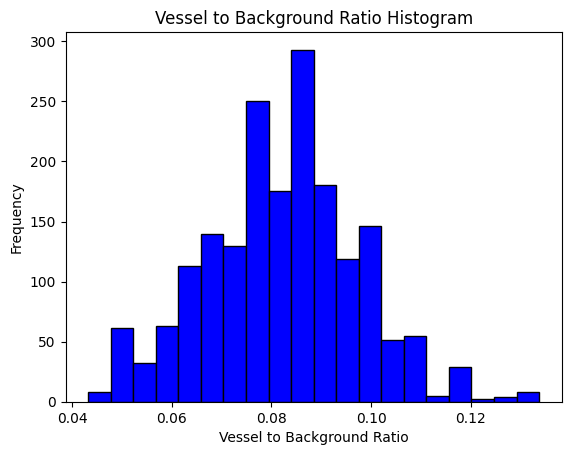

In [ ]:

list_of_keys = list(vessel_ratios.keys())
list_of_values = list(vessel_ratios.values())

# ploting histogram
plt.hist(list_of_values, bins = 20, color ='blue', edgecolor= 'black')
plt.xlabel('Vessel to Background Ratio')
plt.ylabel('Frequency')
plt.title('Vessel to Background Ratio Histogram')
plt.show()

In [ ]:
low = np.percentile(list_of_values , 30)
mid = np.percentile(list_of_values, 65)
high = np.percentile(list_of_values , 85)
print(f"threshold : {low, mid, high}")

low_den = []
med_den = []
high_den = []

for key,value in vessel_ratios.items():
    if value< low:
        low_den.append(key)
    elif value < mid:
        med_den.append(key)
    else:
        high_den.append(key)


print(len(low_den))
print(len(med_den))
print(len(high_den))

threshold : (0.07503890991210938, 0.08735275268554688, 0.09808731079101562)
555
654
655


In [ ]:
import os 
print(os.getcwd())

/home/user-123/Project/Unet_Data/Unet_Data


In [ ]:
os.chdir("/home/user-123/Downloads/Unet-20241120T101157Z-001/Unet/Retina-Blood-Vessel-Segmentation-in-PyTorch/UNET")
!ls

data.py  img	  model.py     README.md  test.py   utils.py
files	 loss.py  __pycache__  results	  train.py


In [ ]:
os.getcwd()

'/home/user-123/Downloads/Unet-20241120T101157Z-001/Unet/Retina-Blood-Vessel-Segmentation-in-PyTorch/UNET'

Training Of Image

In [ ]:
import os
import time
from glob import glob

import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from data import DriveDataset
from model import build_unet
from loss import DiceLoss, DiceBCELoss
from utils import seeding, create_dir, epoch_time
from sklearn.model_selection import StratifiedKFold as skf

def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss


def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Directories """
    info = "/home/user-123/Project/Unet_Data/Unet_Data/Stratified-Kfold/NEWData/files"
    create_dir(info)

    """ Load dataset """
    all_images = sorted(os.listdir("/home/user-123/Project/Unet_Data/Unet_Data/Stratified-Kfold/NEWData/images"))
    all_masks = sorted(os.listdir("/home/user-123/Project/Unet_Data/Unet_Data/Stratified-Kfold/NEWData/mask"))
    # print(all_images[:3])
    labels = []

    for mask in all_masks:
        if mask in low_den:
            labels.append(0)
        elif mask in med_den:
            labels.append(1)
        elif mask in high_den:
            labels.append(2)

    n_splits = 5
    skf = skf(n_splits = n_splits, shuffle = True, random_state = 42)
    for fold, (train_idx, val_idx) in enumerate(skf.split(list(zip(all_images, all_masks)), labels)):

        train_images = [all_images[i] for i in train_idx]
        train_masks = [all_masks[i] for i in train_idx]
        train_labels = [labels[i] for i in train_idx]
        valid_images = [all_images[i] for i in val_idx]
        valid_masks = [all_masks[i] for i in val_idx]
        valid_labels = [labels[i] for i in val_idx]

        data_str = f"Fold: {fold + 1}\n"
        data_str += f"Dataset Size:\nTrain: {len(train_images)} - Valid: {len(valid_images)}\n"
        # data_str += f"Labels:\nTrain: 0:{train_labels.count(0)} 1:{train_labels.count(1)} 2:{train_labels.count(2)} - Valid: 0:{valid_labels.count(0)} 1:{valid_labels.count(1)} 2:{valid_labels.count(2)}\n"
        print(data_str)

        # Print out the train and validation sets for each fold
        # print(f"Fold {fold + 1}")
        print(f"Train Images: {train_images}")
        print(f"Train mask: {train_masks}")
        print(f"Train Labels: {train_labels}")
        z = train_labels.count(0)
        o = train_labels.count(1)
        t = train_labels.count(2)
        print(f"0: {z}, 1: {o}, 2: {t}")
        print(f"Validation Images: {valid_images}")
        print(f"validation masks: {valid_masks}")
        print(f"Validation Labels: {valid_labels}")
        z = valid_labels.count(0)
        o = valid_labels.count(1)
        t = valid_labels.count(2)
        print(f"0: {z}, 1: {o}, 2: {t}")
        print()

        """ Hyperparameters """
        H = 512
        W = 512
        size = (H, W)
        batch_size = 2
        num_epochs = 10
        lr = 1e-4
        checkpoint_path = os.path.join(info, f"files_fold_{fold+1}.pth")

        """coveerting train_images list to path for dataset and loader"""
        train_images = [os.path.join("/home/user-123/Project/Unet_Data/Unet_Data/Stratified-Kfold/NEWData/images", i) for i in train_images]
        train_masks = [os.path.join("/home/user-123/Project/Unet_Data/Unet_Data/Stratified-Kfold/NEWData/mask", i) for i in train_masks]
        # print(train_images[:3])
        valid_images = [os.path.join("/home/user-123/Project/Unet_Data/Unet_Data/Stratified-Kfold/NEWData/images", i) for i in valid_images]
        valid_masks = [os.path.join("/home/user-123/Project/Unet_Data/Unet_Data/Stratified-Kfold/NEWData/mask", i) for i in valid_masks]

        """ Dataset and loader """
        train_dataset = DriveDataset(train_images, train_masks)
        valid_dataset = DriveDataset(valid_images, valid_masks)

        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2
        )

        valid_loader = DataLoader(
            dataset=valid_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2
        )

        device = torch.device('cuda')   ## GTX 1060 6GB
        model = build_unet()
        model = model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
        loss_fn = DiceBCELoss()

        """ Training the model """
        best_valid_loss = float("inf")

        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss = train(model, train_loader, optimizer, loss_fn, device)
            valid_loss = evaluate(model, valid_loader, loss_fn, device)

            """ Saving the model """
            if valid_loss < best_valid_loss:
                data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
                print(data_str)

                best_valid_loss = valid_loss
                torch.save(model.state_dict(), checkpoint_path)

            end_time = time.time()
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)

            data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
            data_str += f'\tTrain Loss: {train_loss:.3f}\n'
            data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
            print(data_str)

Fold: 1
Dataset Size:
Train: 1491 - Valid: 373

Train Images: ['CHASE_test_image_01_0.png', 'CHASE_test_image_01_1.png', 'CHASE_test_image_01_3.png', 'CHASE_test_image_01_4.png', 'CHASE_test_image_01_6.png', 'CHASE_test_image_01_7.png', 'CHASE_test_image_02_0.png', 'CHASE_test_image_02_1.png', 'CHASE_test_image_02_2.png', 'CHASE_test_image_02_3.png', 'CHASE_test_image_02_4.png', 'CHASE_test_image_02_7.png', 'CHASE_test_image_03_0.png', 'CHASE_test_image_03_1.png', 'CHASE_test_image_03_2.png', 'CHASE_test_image_03_3.png', 'CHASE_test_image_03_5.png', 'CHASE_test_image_03_6.png', 'CHASE_test_image_03_7.png', 'CHASE_test_image_04_0.png', 'CHASE_test_image_04_1.png', 'CHASE_test_image_04_3.png', 'CHASE_test_image_04_4.png', 'CHASE_test_image_04_5.png', 'CHASE_test_image_04_6.png', 'CHASE_test_image_04_7.png', 'CHASE_test_image_05_2.png', 'CHASE_test_image_05_3.png', 'CHASE_test_image_05_4.png', 'CHASE_test_image_05_6.png', 'CHASE_test_image_05_7.png', 'CHASE_test_image_06_0.png', 'CHASE_te

/home/user-123/Project/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Valid loss improved from inf to 0.5566. Saving checkpoint: /home/user-123/Project/Unet_Data/Unet_Data/Stratified-Kfold/NEWData/files/files_fold_1.pth
Epoch: 01 | Epoch Time: 6m 46s
	Train Loss: 0.779
	 Val. Loss: 0.557

Valid loss improved from 0.5566 to 0.4184. Saving checkpoint: /home/user-123/Project/Unet_Data/Unet_Data/Stratified-Kfold/NEWData/files/files_fold_1.pth
Epoch: 02 | Epoch Time: 6m 45s
	Train Loss: 0.460
	 Val. Loss: 0.418

Valid loss improved from 0.4184 to 0.3979. Saving checkpoint: /home/user-123/Project/Unet_Data/Unet_Data/Stratified-Kfold/NEWData/files/files_fold_1.pth
Epoch: 03 | Epoch Time: 6m 45s
	Train Loss: 0.392
	 Val. Loss: 0.398

Valid loss improved from 0.3979 to 0.3948. Saving checkpoint: /home/user-123/Project/Unet_Data/Unet_Data/Stratified-Kfold/NEWData/files/files_fold_1.pth
Epoch: 04 | Epoch Time: 6m 45s
	Train Loss: 0.369
	 Val. Loss: 0.395

Valid loss improved from 0.3948 to 0.3634. Saving checkpoint: /home/user-123/Project/Unet_Data/Unet_Data/Strati

KeyboardInterrupt: 

valuaton Matrix Results

In [ ]:
import os, time
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

from model import build_unet
from utils import create_dir, seeding

def calculate_metrics(y_true, y_pred):
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    # Dice Score (similar to F1 score in binary cases)
    score_dice = (2 * np.sum(y_true * y_pred)) / (np.sum(y_true) + np.sum(y_pred) + 1e-10)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc, score_dice]

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Folders """
    create_dir("results")

    """ Load dataset """
    test_x = sorted(glob("/home/user-123/Project/dataset/new_data2/test/image/*.png"))
    test_y = sorted(glob("/home/user-123/Project/dataset/new_data2/test/mask/*.png"))

    """ Hyperparameters """
    H, W = 512, 512
    size = (W, H)
    checkpoint_path = "files/checkpoint.pth"

    """ Load the checkpoint """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = build_unet()
    model = model.to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  # Adding an extra slot for Dice Score
    time_taken = []

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)  # (512, 512, 3)
        x = np.transpose(image, (2, 0, 1))       # (3, 512, 512)
        x = x / 255.0
        x = np.expand_dims(x, axis=0)            # (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x).to(device)

        """ Reading mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  # (512, 512)
        y = np.expand_dims(mask, axis=0)            # (1, 512, 512)
        y = y / 255.0
        y = np.expand_dims(y, axis=0)               # (1, 1, 512, 512)
        y = y.astype(np.float32)
        y = torch.from_numpy(y).to(device)

        with torch.no_grad():
            """ Prediction and Calculating FPS """
            start_time = time.time()
            pred_y = model(x)
            pred_y = torch.sigmoid(pred_y)
            total_time = time.time() - start_time
            time_taken.append(total_time)

            score = calculate_metrics(y, pred_y)
            metrics_score = list(map(add, metrics_score, score))

            pred_y = pred_y[0].cpu().numpy()       # (1, 512, 512)
            pred_y = np.squeeze(pred_y, axis=0)    # (512, 512)
            pred_y = pred_y > 0.5
            pred_y = np.array(pred_y, dtype=np.uint8)

        """ Saving masks """
        ori_mask = mask_parse(mask)  # Since mask is already a NumPy array, no need for .cpu()

        pred_mask = mask_parse(pred_y)
        line = np.ones((size[1], 10, 3)) * 128

        cat_images = np.concatenate([image, line, ori_mask, line, pred_mask * 255], axis=1)
        cv2.imwrite(f"results/{name}.png", cat_images)

    """ Average Metrics """
    jaccard = metrics_score[0] / len(test_x)
    f1 = metrics_score[1] / len(test_x)
    recall = metrics_score[2] / len(test_x)
    precision = metrics_score[3] / len(test_x)
    acc = metrics_score[4] / len(test_x)
    dice = metrics_score[5] / len(test_x)

    print(f"Jaccard: {jaccard:.4f} - F1: {f1:.4f} - Recall: {recall:.4f} - Precision: {precision:.4f} - Acc: {acc:.4f} - Dice: {dice:.4f}")

    fps = 1 / np.mean(time_taken)
    print("FPS: ", fps)


/tmp/ipykernel_6160/152452289.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))
100%|██████████| 1

Jaccard: 0.7321 - F1: 0.8451 - Recall: 0.8435 - Precision: 0.8490 - Acc: 0.9735 - Dice: 0.8451
FPS:  25.330737231673083


Dice Score Calculation

  0%|          | 0/10 [00:00<?, ?it/s]

Input shape: torch.Size([1, 3, 512, 512])
Target shape: torch.Size([1, 1, 512, 512])


 10%|█         | 1/10 [00:00<00:02,  4.19it/s]

0_0
[0.723483237307142, 0.8395593547373853, 0.8474499501766465, 0.831814342239808, 0.9727210998535156, 0.8395593547373834]
/n
Input shape: torch.Size([1, 3, 512, 512])
Target shape: torch.Size([1, 1, 512, 512])


 20%|██        | 2/10 [00:00<00:01,  4.28it/s]

1_0
[0.727607018665814, 0.8423293154107767, 0.8591250176978621, 0.8261777253335754, 0.9740028381347656, 0.8423293154107747]
/n
Input shape: torch.Size([1, 3, 512, 512])
Target shape: torch.Size([1, 1, 512, 512])


 30%|███       | 3/10 [00:00<00:01,  4.32it/s]

2_0
[0.7156595280316465, 0.8342675412442855, 0.7847874051082607, 0.8904068904068904, 0.9681930541992188, 0.8342675412442837]
/n
Input shape: torch.Size([1, 3, 512, 512])
Target shape: torch.Size([1, 1, 512, 512])


 40%|████      | 4/10 [00:00<00:01,  4.36it/s]

3_0
[0.7475581003704951, 0.8555459188590151, 0.8914102113559917, 0.8224558803094169, 0.9771270751953125, 0.855545918859013]
/n
Input shape: torch.Size([1, 3, 512, 512])
Target shape: torch.Size([1, 1, 512, 512])


 50%|█████     | 5/10 [00:01<00:01,  4.42it/s]

4_0
[0.6950837051106498, 0.8201172638436482, 0.8104238553844569, 0.8300453634349615, 0.9736671447753906, 0.820117263843646]
/n
Input shape: torch.Size([1, 3, 512, 512])
Target shape: torch.Size([1, 1, 512, 512])


 60%|██████    | 6/10 [00:01<00:00,  4.37it/s]

5_0
[0.7526547330097088, 0.8588739343056216, 0.880713588355374, 0.8380912162162162, 0.9751205444335938, 0.8588739343056198]
/n
Input shape: torch.Size([1, 3, 512, 512])
Target shape: torch.Size([1, 1, 512, 512])


 70%|███████   | 7/10 [00:01<00:00,  4.35it/s]

6_0
[0.7099413271630444, 0.8303692248211869, 0.8716960073055654, 0.7927836478567803, 0.9732208251953125, 0.8303692248211849]
/n
Input shape: torch.Size([1, 3, 512, 512])
Target shape: torch.Size([1, 1, 512, 512])


 80%|████████  | 8/10 [00:01<00:00,  4.38it/s]

7_0
[0.7537850948111128, 0.8596094208364764, 0.8493230093991967, 0.8701480507360115, 0.9744415283203125, 0.8596094208364746]
/n
Input shape: torch.Size([1, 3, 512, 512])
Target shape: torch.Size([1, 1, 512, 512])


 90%|█████████ | 9/10 [00:02<00:00,  4.39it/s]

8_0
[0.7690097947599764, 0.8694240100172171, 0.8461157654226961, 0.8940527925317882, 0.9745407104492188, 0.8694240100172154]
/n
Input shape: torch.Size([1, 3, 512, 512])
Target shape: torch.Size([1, 1, 512, 512])


100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

9_0
[0.7258353891006952, 0.8411409265154961, 0.794330592710762, 0.8938138635735985, 0.9720191955566406, 0.8411409265154942]
/n
[[0.723483237307142, 0.8395593547373853, 0.8474499501766465, 0.831814342239808, 0.9727210998535156, 0.8395593547373834], [0.727607018665814, 0.8423293154107767, 0.8591250176978621, 0.8261777253335754, 0.9740028381347656, 0.8423293154107747], [0.7156595280316465, 0.8342675412442855, 0.7847874051082607, 0.8904068904068904, 0.9681930541992188, 0.8342675412442837], [0.7475581003704951, 0.8555459188590151, 0.8914102113559917, 0.8224558803094169, 0.9771270751953125, 0.855545918859013], [0.6950837051106498, 0.8201172638436482, 0.8104238553844569, 0.8300453634349615, 0.9736671447753906, 0.820117263843646], [0.7526547330097088, 0.8588739343056216, 0.880713588355374, 0.8380912162162162, 0.9751205444335938, 0.8588739343056198], [0.7099413271630444, 0.8303692248211869, 0.8716960073055654, 0.7927836478567803, 0.9732208251953125, 0.8303692248211849], [0.7537850948111128, 0.8

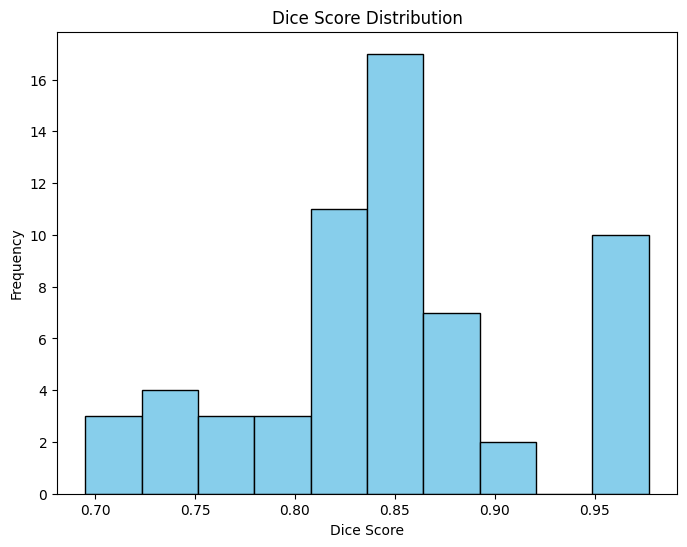

In [ ]:
import seaborn as sns
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm

# Assuming `calculate_metrics` is already defined to compute Dice or other metrics
# Define if not available: e.g., def calculate_metrics(true_mask, pred_mask): ...

def plot_metric_distribution(scores, metric_name="Metric"):
    """Plot the distribution of a metric."""
    plt.figure(figsize=(8, 6))
    if not scores:
        print("Warning: No scores to plot.")
        return

    # Flatten all scores into a 1D array
    all_scores = np.array(scores).flatten()
    
    plt.hist(all_scores, bins=10, color='skyblue', edgecolor='black')  # Single dataset
    plt.title(f'{metric_name} Distribution')
    plt.xlabel(metric_name)
    plt.ylabel('Frequency')
    plt.show()


# Lists to store true masks, predictions, and Dice scores
true_masks = []
predictions = []
dice_scores = []  # For storing Dice scores per sample

# Iterating over test dataset
for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
    """Extract the name"""
    name = x.split("/")[-1].split(".")[0]

    """Reading image"""
    image = cv2.imread(x, cv2.IMREAD_COLOR)  # (512, 512, 3)
    x = np.transpose(image, (2, 0, 1))  # (3, 512, 512)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)  # (1, 3, 512, 512)
    x = x.astype(np.float32)
    x = torch.from_numpy(x).to(device)
    print(f"Input shape: {x.shape}")

    """Reading mask"""
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  # (512, 512)
    y = np.expand_dims(mask, axis=0)  # (1, 512, 512)
    y = y / 255.0
    y = np.expand_dims(y, axis=0)  # (1, 1, 512, 512)
    y = torch.from_numpy(y).to(device)
    print(f"Target shape: {y.shape}")

    with torch.no_grad():
        """Prediction"""
        pred_y = model(x)  # Raw model output
        pred_y = torch.sigmoid(pred_y)  # Apply sigmoid activation for probabilities
        pred_y = (pred_y > 0.5).float()  # Binarize predictions

        """Calculate metrics"""
        dice_score = calculate_metrics(y, pred_y)  # Compute Dice score or other metric
        dice_scores.append(dice_score)
        print(name)
        print(dice_score)
        print("/n")
        """Store results"""
        true_masks.append(y.cpu().numpy())  # Ground truth mask
        predictions.append(pred_y.cpu().numpy())  # Predicted mask

print(dice_scores)
print(np.array(dice_scores).shape)

# Plot Dice score distribution
plot_metric_distribution(dice_scores, metric_name="Dice Score")


In [ ]:
# prompt: create a snippet to print DIce loss and DiceBCEloss

# Assuming DiceLoss and DiceBCELoss are defined in your 'loss.py' file

import torch
import torch.nn.functional as F

# Example usage (replace with your actual inputs and targets)
inputs = x
inputs = torch.argmax(inputs, dim=1, keepdim=True)  # Shape: [1, 1, 512, 512]

targets = y

inputs = inputs.float()
targets = targets.float()
print(x.shape, y.shape)
# Calculate Dice loss
dice_loss_fn = DiceLoss()
dice_loss = dice_loss_fn(inputs, targets)
print(f"Dice Loss: {dice_loss}")


# Calculate Dice-BCE loss
dice_bce_loss_fn = DiceBCELoss()
dice_bce_loss = dice_bce_loss_fn(inputs, targets)
print(f"Dice-BCE Loss: {dice_bce_loss}")

torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 512, 512])
Dice Loss: 0.822105348110199
Dice-BCE Loss: 2.563338041305542


Testing 

Image: /home/user-123/Project/dataset/new_data2/test/image/4_0.png
Mask: /home/user-123/Project/dataset/new_data2/test/mask/4_0.png


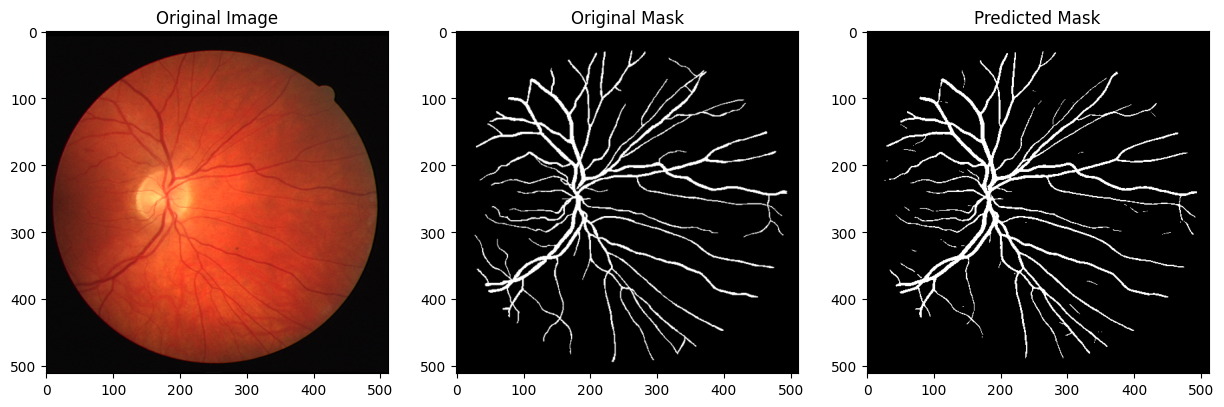

Image: /home/user-123/Project/dataset/new_data2/test/image/5_0.png
Mask: /home/user-123/Project/dataset/new_data2/test/mask/5_0.png


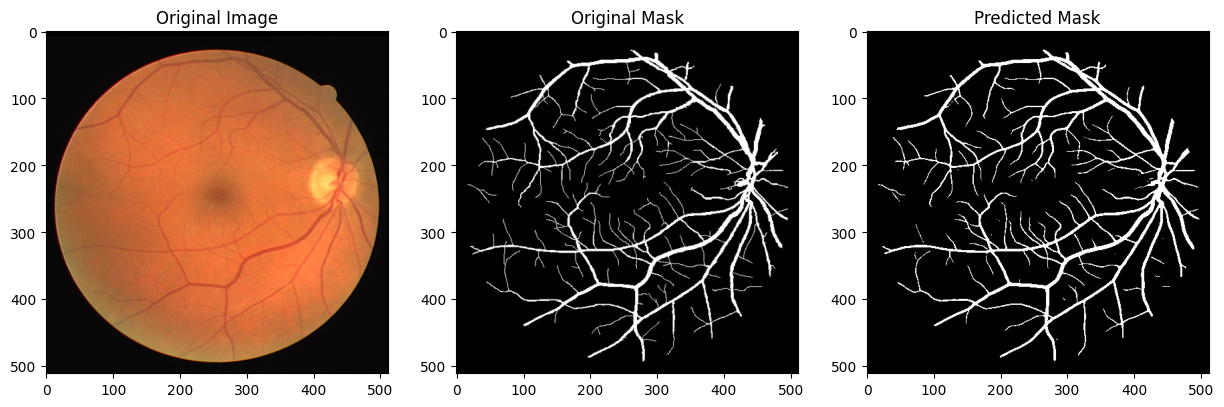

Image: /home/user-123/Project/dataset/new_data2/test/image/8_0.png
Mask: /home/user-123/Project/dataset/new_data2/test/mask/8_0.png


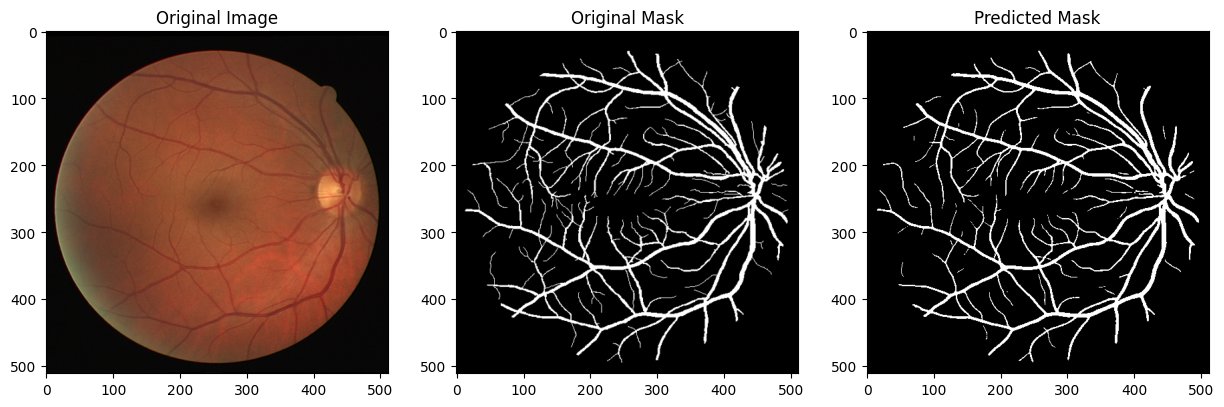

Image: /home/user-123/Project/dataset/new_data2/test/image/1_0.png
Mask: /home/user-123/Project/dataset/new_data2/test/mask/1_0.png


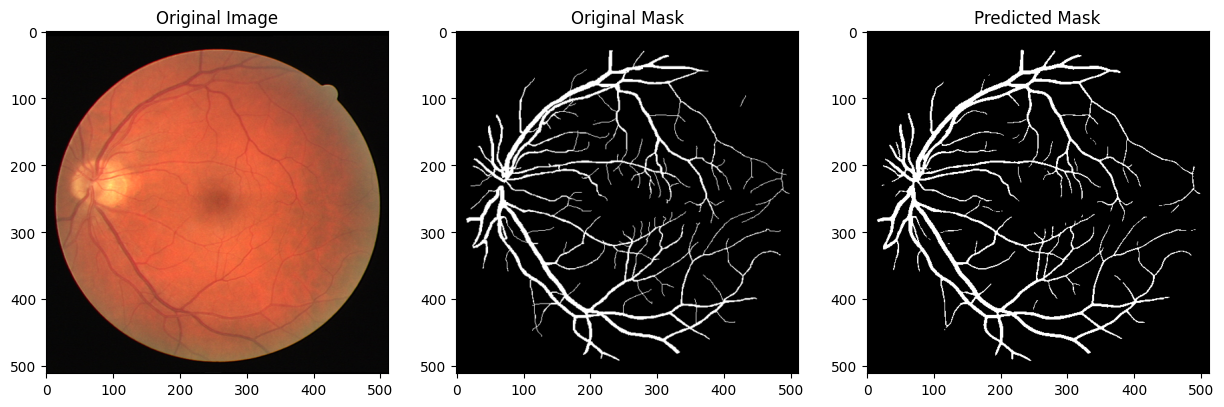

In [ ]:
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt

def predict_image(image_paths, mask_paths, model, device, size=(512, 512)):
    """Predict and visualize results for images and masks."""
    for image_path, mask_path in zip(image_paths, mask_paths):
        print(f"Image: {image_path}")
        print(f"Mask: {mask_path}")

        # Load and preprocess the image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            print(f"Error: Unable to load image {image_path}.")
            continue

        x = cv2.resize(image, size)  # Resize image for the model
        x = np.transpose(x, (2, 0, 1))  # (3, H, W)
        x = x / 255.0
        x = np.expand_dims(x, axis=0)  # (1, 3, H, W)
        x = x.astype(np.float32)
        x = torch.from_numpy(x).to(device)

        # Load and preprocess the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Error: Unable to load mask {mask_path}.")
            continue

        y = cv2.resize(mask, size)  # Resize mask for consistency
        y = y / 255.0
        y = np.expand_dims(y, axis=0)  # (1, H, W)
        y = np.expand_dims(y, axis=0)  # (1, 1, H, W)
        y = y.astype(np.float32)
        y = torch.from_numpy(y).to(device)

        # Predict the mask
        with torch.no_grad():
            pred_y = model(x)
            pred_y = torch.sigmoid(pred_y)

        pred_y = pred_y[0].cpu().numpy()  # (1, H, W)
        pred_y = np.squeeze(pred_y, axis=0)  # (H, W)
        pred_y = pred_y > 0.5
        pred_y = np.array(pred_y, dtype=np.uint8)

        # Resize the mask back to original dimensions for visualization
        pred_y_resized = cv2.resize(pred_y, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Convert the resized prediction mask to 3 channels
        pred_y_color = np.expand_dims(pred_y_resized, axis=-1)  # (H, W, 1)
        pred_y_color = np.concatenate([pred_y_color] * 3, axis=-1)  # (H, W, 3)

        # Display the original image, ground truth mask, and prediction
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Original Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(pred_y_color * 255)
        plt.title('Predicted Mask')

        plt.show()

# Usage example
image_paths = [
    "/home/user-123/Project/dataset/new_data2/test/image/4_0.png",
    "/home/user-123/Project/dataset/new_data2/test/image/5_0.png",
    "/home/user-123/Project/dataset/new_data2/test/image/8_0.png",
    "/home/user-123/Project/dataset/new_data2/test/image/1_0.png",
]

mask_paths = [
    "/home/user-123/Project/dataset/new_data2/test/mask/4_0.png",
    "/home/user-123/Project/dataset/new_data2/test/mask/5_0.png",
    "/home/user-123/Project/dataset/new_data2/test/mask/8_0.png",
    "/home/user-123/Project/dataset/new_data2/test/mask/1_0.png",
]

predict_image(image_paths, mask_paths, model, device)


PR Curve

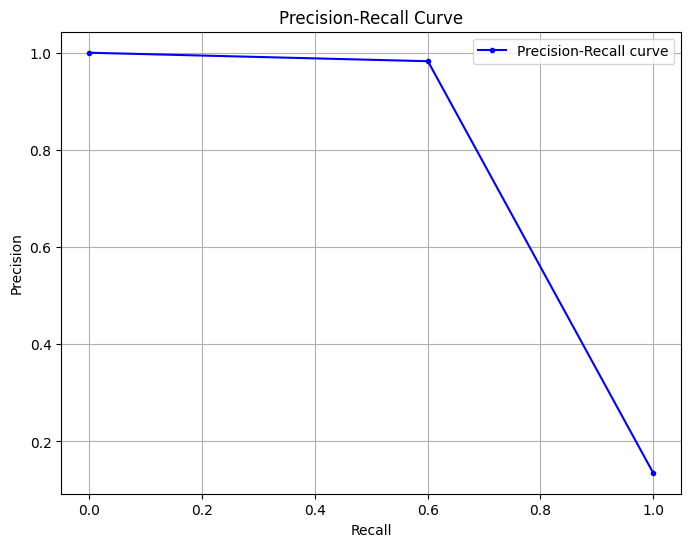

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred, threshold=0.5):
    """ Plot Precision-Recall Curve for binary classification. """

    # Flatten and binarize ground truth and predictions
    # y_true is already a numpy array, no need to call .cpu() or .numpy()
    y_true = y_true.flatten()  # Flatten ground truth
    # y_pred is already a numpy array, no need to call .cpu() or .numpy()
    y_pred = y_pred.flatten()  # Flatten predictions

    # The binarization happens before in this case and doesn't need to happen here
    # y_true = (y_true > threshold).astype(int)  # Binarize ground truth
    # y_pred = (y_pred > threshold).astype(int)  # Binarize predictions

    precision, recall, _ = precision_recall_curve(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', color='b', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage for Precision-Recall curve
# Ensure you are using the probabilities from your predictions
pred_y_prob = torch.sigmoid(pred_y)  # Get probabilities from the model output

# Move tensors to CPU and convert to NumPy arrays before plotting
# Remove .cpu() and .numpy() calls for mask as it's already a NumPy array
plot_precision_recall_curve((mask > 0.5), (pred_y_prob > 0.5).cpu().numpy())